Generate plots

In [12]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [13]:
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
fig_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_abctau\\figs\\'

In [14]:
save_fig = False

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trails (сoncat)

ACF vs iSTTC, full signal

PearsonR vs iSTTC (concat and avg), trails

In [15]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_all_long_df: four methods in one wide (ACF, iSTTC, PersonR, iSTTC trails (сoncat))
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat)')
df_all = pd.read_pickle(results_folder / "summary_tau_all_long_df_all_units_with_abctau_dst_gamma_0_01_50.pkl")
# spec_all = {
#     "tau_diff_rel_acf": "acf_full",
#     "tau_diff_rel_isttc": "isttc_full",
#     "tau_diff_rel_pearsonr": "pearsonr_trial_avg",
#     "tau_diff_rel_sttc_concat": "sttc_trial_concat",
# }
# tau_full_wide_df = long_to_wide(df_all, spec_all)
# inspect(tau_full_wide_df, "tau_full_wide_df (all)")

# # From summary_tau_full_long_df: acf and isttc
# print('\nACF, iSTTC')
# df_full = pd.read_pickle(results_folder / "summary_tau_full_long_df.pkl")
# spec_full = {
#     "tau_diff_rel_acf": "acf_full",
#     "tau_diff_rel_isttc": "isttc_full",
# }
# tau_full_wide_df = long_to_wide(df_full, spec_full)
# inspect(tau_full_wide_df, "tau_full_wide_df (full)")

# # From summary_tau_trials_long_df: pearsonr and isttc concat
# print('\nPearsonR, iSTTC concat')
# df_trials = pd.read_pickle(results_folder / "summary_tau_trials_long_df.pkl")
# spec_trials_concat = {
#     "tau_diff_rel_pearsonr": "pearsonr_trial_avg",
#     "tau_diff_rel_sttc_concat": "sttc_trial_concat",
# }
# tau_trials_pearsonr_con_wide_df = long_to_wide(df_trials, spec_trials_concat)
# inspect(tau_trials_pearsonr_con_wide_df, "tau_trials_pearsonr_con_wide_df")

# # From summary_tau_trials_long_df: pearsonr and sttc avg
# print('\nPearsonR, STTC avg')
# spec_trials_avg = {
#     "tau_diff_rel_pearsonr": "pearsonr_trial_avg",
#     "tau_diff_rel_sttc_avg": "sttc_trial_avg",  # was concat by mistake
# }
# tau_trials_pearsonr_avg_wide_df = long_to_wide(df_trials, spec_trials_avg)
# inspect(tau_trials_pearsonr_avg_wide_df, "tau_trials_pearsonr_avg_wide_df")

# # From summary_tau_full_long_var_length_df: acf and isttc, varying signal length
# print('\nACF, iSTTC')
# summary_tau_full_long_var_length_df = pd.read_pickle(results_folder / 'summary_tau_full_long_var_length_df.pkl')
# inspect(summary_tau_full_long_var_length_df, "summary_tau_full_long_var_length_df")

# # From summary_tau_trials_long_var_num_trials_df: pearsonr and isttc concat, varying number of trials
# print('\nPearsonR, iSTTC concat')
# summary_tau_trials_long_var_num_trials_df = pd.read_pickle(results_folder / 'summary_tau_trials_long_var_num_trials_df.pkl')
# inspect(summary_tau_trials_long_var_num_trials_df, "summary_tau_trials_long_var_num_trials_df")

ACF, iSTTC, PersonR, iSTTC trails (сoncat)


In [16]:
df_all.groupby(by='method')['tau_diff_rel'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
abctau_full,33.0,41.657740,42.311656,5.131112,18.209297,34.467806,45.683565,2.367629e+02
acf_full,33.0,43.164405,130.657940,0.372701,3.910259,11.856417,23.346929,7.540217e+02
isttc_full,33.0,23.693521,36.960713,0.807392,4.211585,9.074909,27.258890,1.963821e+02
pearsonr_trial_avg,29.0,298048.954171,727880.443432,9.226478,42.071480,68.112862,182.226402,2.487379e+06
sttc_trial_concat,33.0,110876.541130,444881.685910,1.867107,33.268124,63.060429,97.918227,1.990606e+06


### Prepare extra dataframes for plotting 

In [17]:
# Dataframe to plot now many spike trains for a method have a REE within certain percentage
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

df = df_all.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_plot_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_plot_error_df = tau_plot_error_df.reset_index()
tau_plot_error_long_df = tau_plot_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_plot_error_long_df

,method,interval,percentage
0,abctau_full,+-100,93.939394
1,acf_full,+-100,93.939394
2,isttc_full,+-100,96.969697
3,pearsonr_trial_avg,+-100,57.575758
4,sttc_trial_concat,+-100,84.848485
5,abctau_full,+-75,93.939394
6,acf_full,+-75,90.909091
7,isttc_full,+-75,96.969697
8,pearsonr_trial_avg,+-75,48.484848
9,sttc_trial_concat,+-75,60.606061


In [18]:
# get percentage of units with tau_ms in 100% error range
mask = df_all['tau_diff_rel'].between(0, 100)
tau_plot_long_0_100perc_df = (
    df_all
    .groupby('method')
    .agg(
        total       = ('tau_diff_rel', 'size'),
        in_range    = ('tau_diff_rel', lambda x: x.between(0,100).sum())
    )
)
tau_plot_long_0_100perc_df['percent_in_range'] = tau_plot_long_0_100perc_df['in_range'] / tau_plot_long_0_100perc_df['total'] * 100
tau_plot_long_0_100perc_df = tau_plot_long_0_100perc_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_plot_long_0_100perc_df

,total,in_range,percent_in_range
method,,,
abctau_full,33,31,93.9%
acf_full,33,31,93.9%
isttc_full,33,32,97.0%
pearsonr_trial_avg,33,19,57.6%
sttc_trial_concat,33,28,84.8%


### Plots

In [19]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 
color_abctau = '#B4464B'

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat, color_abctau]

In [20]:
def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        ("abctau_full",     color_abctau,     "abctau_full"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

def hexbin_pair(
    df, *,
    x1, x2, y,
    c,                            # 1D array/Series with same index as df
    title,
    xlabel1, xlabel2, ylabel,
    xticks2=None, yticks=None,         
    ylim=None,
    gridsize=10,
    cmap="RdBu_r",
    vcenter=0,
    mincnt=1,
    save_path_png=None,           # full path or None
    save_path_svg=None,           # full path or None
):
    """Two-panel hexbin with the SAME symmetric color scale based on 95th pct."""
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    norm = TwoSlopeNorm(vcenter=vcenter)

    hb0 = axes[0].hexbin(
        x=df[x1], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )
    hb1 = axes[1].hexbin(
        x=df[x2], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )

    # Symmetric colorbar limits from both panels (95th percentile of |values|)
    arr = np.hstack([hb0.get_array(), hb1.get_array()])
    bar_lim = np.percentile(np.abs(arr), 95)
    hb0.set_clim(-bar_lim, bar_lim)
    hb1.set_clim(-bar_lim, bar_lim)

    fig.colorbar(hb0, ax=axes[0], shrink=1)
    fig.colorbar(hb1, ax=axes[1], shrink=1)

    axes[0].set_xlabel(xlabel1)
    axes[1].set_xlabel(xlabel2)
    if xticks2 is not None:
        axes[1].set_xticks(xticks2)

    fig.suptitle(title, y=1.05)

    for ax in axes.flat:
        sns.despine(ax=ax)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if yticks is not None:
            ax.set_yticks(yticks)

    if save_path_png:
        fig.savefig(save_path_png, bbox_inches="tight", dpi=300)
    if save_path_svg:
        fig.savefig(save_path_svg, bbox_inches="tight")

    return fig, axes

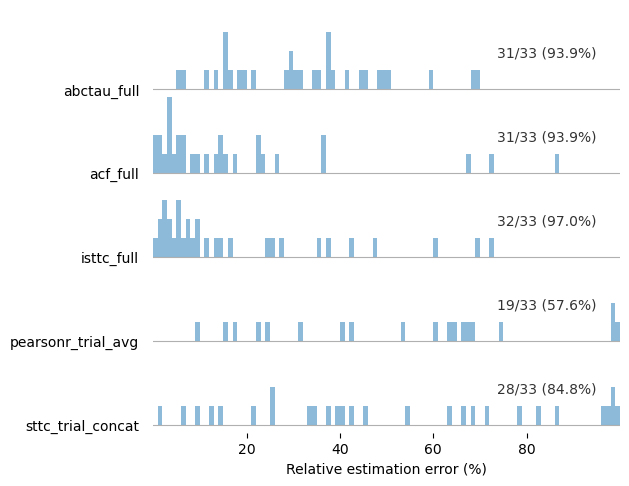

In [21]:
fig, axes = joypy.joyplot(data=df_all.query('tau_diff_rel >= 0 and tau_diff_rel <= 100'),
    by='method',
    column='tau_diff_rel',
    #range_style='own',
    ylim = 'max',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0,100]
)

#axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Relative estimation error (%)')
#fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)


method_order = [
    'abctau_full',
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_plot_long_0_100perc_df.at[method, 'total']
    inn    = tau_plot_long_0_100perc_df.at[method, 'in_range']
    pct    = tau_plot_long_0_100perc_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + 'parametric_5_methods_one_trial_impl_rel_error_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'parametric_5_methods_one_trial_impl_rel_error_hist.svg' , bbox_inches='tight')

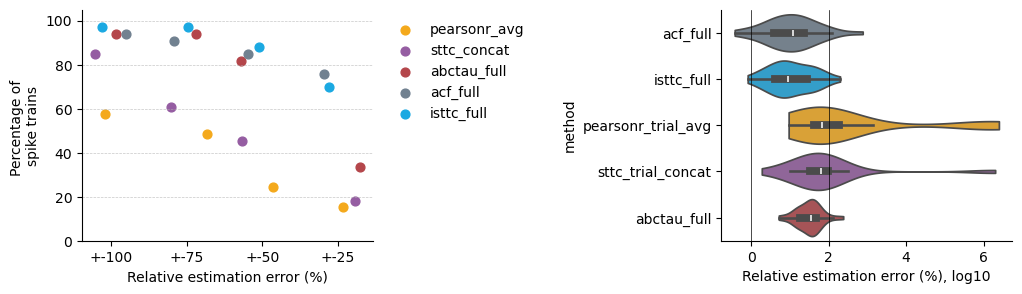

In [22]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

plot_one_threshold_jittered_lines(axes[0],
    tau_plot_error_long_df,
    jitter=0.3, seed=42)
axes[0].set_ylabel('Percentage of \nspike trains')
axes[0].set_xlabel('Relative estimation error (%)')
axes[0].set_ylim([0, 105])
axes[0].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

df_all['tau_diff_rel_log10'] = np.log10(df_all['tau_diff_rel'])
method_order = ['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_full']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=df_all , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

if save_fig:
    plt.savefig(fig_folder + 'parametric_5_methods_taus_rel_error_one_trials_impl_dst_gamma.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'parametric_5_methods_taus_rel_error_one_trials_impl_dst_gamma.svg' , bbox_inches='tight')

#### iSTTC vs ACF on full signal 

Figure 2C

Figure 2D (in the paper plots generated in R are included)

In [ ]:
c3 = tau_full_wide_df["tau_diff_rel_isttc"] - tau_full_wide_df["tau_diff_rel_acf"]

hexbin_pair(
    tau_full_wide_df,
    x1="fr", x2="tau_ms_true", y="alpha", c=c3,
    title="iSTTC – ACF relative error (|tau−tau_true|/tau_true·100)\n< 0: iSTTC lower error; > 0: ACF lower error",
    xlabel1="Firing rate (Hz)", xlabel2="Intrinsic timescale (ms)", ylabel = "Excitation strength (a.u.)",
    xticks2=np.linspace(50, 300, 6), yticks=np.linspace(0.1, 0.9, 5),
    ylim=[0.1, 0.9],
    save_path_png=fig_folder + "taus_isttc_vs_acf_ree_hexbin.png" if save_fig else None,
    save_path_svg=fig_folder + "taus_isttc_vs_acf_ree_hexbin.svg" if save_fig else None,
)

In [ ]:
c1 = tau_trials_pearsonr_con_wide_df["tau_diff_rel_sttc_concat"] - \
     tau_trials_pearsonr_con_wide_df["tau_diff_rel_pearsonr"]

hexbin_pair(
    tau_trials_pearsonr_con_wide_df,
    x1="fr", x2="tau_ms_true", y="alpha", c=c1,
    title="STTC concat – Pearsonr relative error (|tau−tau_true|/tau_true·100)\n< 0: STTC concat lower error; > 0: Pearsonr lower error",
    xlabel1="Firing rate (Hz)", xlabel2="Intrinsic timescale (ms)", ylabel = "Excitation strength (a.u.)",
    xticks2=np.linspace(50, 300, 6), yticks=np.linspace(0.1, 0.9, 5),
    ylim=[0.1, 0.9],
    save_path_png=fig_folder + "taus_dataset_3_var_rel_diff_trials_pearsonr_concat.png" if save_fig else None,
    save_path_svg=fig_folder + "taus_dataset_3_var_rel_diff_trials_pearsonr_concat.svg" if save_fig else None,
)

In [ ]:
c2 = tau_trials_pearsonr_avg_wide_df["tau_diff_rel_sttc_avg"] - \
     tau_trials_pearsonr_avg_wide_df["tau_diff_rel_pearsonr"]

hexbin_pair(
    tau_trials_pearsonr_avg_wide_df,
    x1="fr", x2="tau_ms_true", y="alpha", c=c2,
    title="STTC avg – Pearsonr relative error (|tau−tau_true|/tau_true·100)\n< 0: STTC avg lower error; > 0: Pearsonr lower error",
    xlabel1="Firing rate (Hz)", xlabel2="Intrinsic timescale (ms)", ylabel = "Excitation strength (a.u.)",
    xticks2=np.linspace(50, 300, 6), yticks=np.linspace(0.1, 0.9, 5),
    ylim=[0.1, 0.9],
    save_path_png=fig_folder + "taus_dataset_3_var_rel_diff_trials_pearsonr_avg.png" if save_fig else None,
    save_path_svg=fig_folder + "taus_dataset_3_var_rel_diff_trials_pearsonr_avg.svg" if save_fig else None,
)

#### iSTTC vs ACF on full signal, Lv

Supp Figure 2C-D, in C, D right and D left inset plots generated in R are used 

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(5, 3), sharey=False)

sns.kdeplot(
    data=tau_full_wide_df, 
    x="lv", 
    fill=True, 
    alpha=0.3,
    ax=axes
)

axes.set_xlabel('Local variation (a.u.)')
sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff_regplot_lv.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_fr_alpha_var_diff_regplot_lv.svg' , bbox_inches='tight')

In [ ]:
tau_full_wide_df_subset = tau_full_wide_df.query('lv >= 1.1 and lv <= 1.4')
c4 = tau_full_wide_df_subset["tau_diff_rel_isttc"] - tau_full_wide_df_subset["tau_diff_rel_acf"]

hexbin_pair(
    tau_full_wide_df_subset,
    x1="fr", x2="tau_ms_true", y="lv", c=c4,
    title="iSTTC – ACF relative error (|tau−tau_true|/tau_true·100)\n< 0: iSTTC lower error; > 0: ACF lower error",
    xlabel1="Firing rate (Hz)", xlabel2="Intrinsic timescale (ms)", ylabel = "Local variation (a.u.)",
    xticks2=np.linspace(50, 300, 6), 
    ylim=[1.09, 1.41],
    gridsize=10,
    cmap="coolwarm",
    vcenter=0,
    mincnt=5,
    save_path_png=fig_folder + "taus_isttc_vs_acf_ree_hexbin.png" if save_fig else None,
    save_path_svg=fig_folder + "taus_isttc_vs_acf_ree_hexbin.svg" if save_fig else None,
)

### ACF vs iSTTC, varying signal length (60, 150, 300, 450, 600 seconds)

In [ ]:
# intervals for error plots
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

df = summary_tau_full_long_var_length_df.copy()
rows = []
for method, sub in df.groupby(by=['method','duration_s']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_2methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_2methods_error_df = tau_2methods_error_df.reset_index()
tau_2methods_error_long_df = tau_2methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_2methods_error_long_df[['method','duration_s']] = pd.DataFrame(
    tau_2methods_error_long_df['method'].tolist(),
    index=tau_2methods_error_long_df.index
)
tau_2methods_error_long_df = tau_2methods_error_long_df.rename(columns={'interval':'error_interval'})
tau_2methods_error_long_df = tau_2methods_error_long_df[['method','duration_s','error_interval','percentage']]

# prep for heatmaps
# ACF
acf = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='acf_full'
]
acf_pivot = acf.pivot(
    index='duration_s',
    columns='error_interval',
    values='percentage'
)

# ISTTC
isttc = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='isttc_full'
]
isttc_pivot = isttc.pivot(
    index='duration_s',
    columns='error_interval',
    values='percentage'
)

diff_pivot = acf_pivot-isttc_pivot
diff_pivot

In [ ]:
col_order = ['+-100', '+-75', '+-50', '+-25']
row_order = sorted(diff_pivot.index, reverse=True)

acf_ordered  = acf_pivot.reindex(index=row_order, columns=col_order)
isttc_ordered  = isttc_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_ordered  = diff_pivot.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

diff_limit = np.max([np.abs(diff_pivot_ordered.min().min()), 
                     np.abs(diff_pivot_ordered.max().max())])

norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)

sns.heatmap(
    acf_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[0]
)
axes[0].set_title("ACF Full: % signals")

sns.heatmap(
    isttc_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[1]
)
axes[1].set_title('iSTTC Full: % signals')

sns.heatmap(
    diff_pivot_ordered,
    cmap="RdBu_r", #"coolwarm", 
    norm=norm,
    cbar_kws={'label': 'Percentage'},
    annot=True, fmt=".2f",
    ax=axes[2]
)
axes[2].set_title('ACF - iSTTC diff')
print(diff_pivot_ordered.min().min())
print(diff_pivot_ordered.max().max())

for ax in axes.flat:
    ax.set_xlabel('REE (%)')
    ax.set_ylabel('Signal length (sec)')
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_duration_5var_heatmaps_colors2_param.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_duration_5var_heatmaps_colors2_param.svg' , bbox_inches='tight')

### PearsonR vs iSTTC (concat), varying number of trials (40, 60, 80, 100)

In [ ]:
# intervals for error plots
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

df = summary_tau_trials_long_var_num_trials_df.copy()
rows = []
for method, sub in df.groupby(by=['method','n_trials']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_2methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_2methods_error_df = tau_2methods_error_df.reset_index()
tau_2methods_error_long_df = tau_2methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_2methods_error_long_df[['method','n_trials']] = pd.DataFrame(
    tau_2methods_error_long_df['method'].tolist(),
    index=tau_2methods_error_long_df.index
)
tau_2methods_error_long_df = tau_2methods_error_long_df.rename(columns={'interval':'error_interval'})
tau_2methods_error_long_df = tau_2methods_error_long_df[['method','n_trials','error_interval','percentage']]

# prep for heatmaps
# ACF
pearsonr_trial_avg = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='pearsonr_trial_avg'
]
pearsonr_trial_avg_pivot = pearsonr_trial_avg.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

# ISTTC
sttc_trial_concat = tau_2methods_error_long_df[
    tau_2methods_error_long_df['method']=='sttc_trial_concat'
]
sttc_trial_concat_pivot = sttc_trial_concat.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

diff_pivot_pearsonr_concat = pearsonr_trial_avg_pivot - sttc_trial_concat_pivot 
diff_pivot_pearsonr_concat

In [ ]:
col_order = ['+-100', '+-75', '+-50', '+-25']

row_order = sorted(diff_pivot_pearsonr_concat.index, reverse=True)

pearsonr_trial_avg_ordered  = pearsonr_trial_avg_pivot.reindex(index=row_order, columns=col_order)
sttc_trial_concat_ordered  = sttc_trial_concat_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_pearsonr_concat_pivot_ordered  = diff_pivot_pearsonr_concat.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

diff_limit = np.max([np.abs(diff_pivot_pearsonr_concat_pivot_ordered.min().min()), 
                     np.abs(diff_pivot_pearsonr_concat_pivot_ordered.max().max())])

norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)
#norm = TwoSlopeNorm(vcenter=0)

sns.heatmap(
    pearsonr_trial_avg_ordered,
    cmap="magma", vmin=0, vmax=85,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[0]
)
axes[0].set_title("Pearsonr avg: % signals")

sns.heatmap(
    sttc_trial_concat_ordered,
    cmap="magma", vmin=0, vmax=85,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[1]
)
axes[1].set_title('STTC concat: % signals')

sns.heatmap(
    diff_pivot_pearsonr_concat_pivot_ordered,
    cmap="RdBu_r", 
    norm=norm,
    cbar_kws={'label': 'Percentage'}, 
    annot=True, fmt=".1f",
    ax=axes[2]
)
axes[2].set_title('iSTTC - PearsonR')

for ax in axes.flat:
    ax.set_xlabel('Error (ms)')
    ax.set_ylabel('N trials')
    
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_parametric_heatmaps.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_parametric_heatmaps.svg' , bbox_inches='tight')